# Graph of iDigBio Specimens over Time

This notebook introduces the basics of loading and analyzing iDigBio data on the [GUODA](http://guoda.bio/) infrastructure hosted by the [ACIS Lab](https://www.acis.ufl.edu/) and [iDigBio](https://www.idigbio.org/). This service is documented in the [GUODA Jupyter service wiki](https://github.com/bio-guoda/guoda-services/wiki/Jupyter-Notebooks) on Github.

As an example, we will create a graph that shows how many specimens in iDigBio were collected during each the past 200 years. The data for this graph is a random sample of 100,000 records from an export of the iDigBio. The field used to determine the year is the interpreted `datecollected` field that iDigBio populates based on Darwin Core terms like `dwc:year` and `dwc:eventDate`.

If you are interested in the capabilities of GUODA, you may want to scroll to the end of this notebook to view the final graph. If you are interested in doing this work yourself, please keep reading.

## Set up

In this document, narrative describing what the code is intended to do and observations about the results is written in [Markdown](https://daringfireball.net/projects/markdown/syntax) cells. Markdown is a simple wiki-style language that can be used for formating text. Comments about the actual code are written inside the code cells themselves and prefixed with "#" so the are not run.

The code for this document is written in [Python](https://docs.python.org/3/tutorial/) and uses the [Apache Spark](https://spark.apache.org/) data analytics framework. The code written in this [Jupyter notebook](http://jupyter-notebook.readthedocs.io/en/latest/) is actually run on servers located at the ACIS lab. All of the needed libraries and Spark configuration are already done and there is nothing to install.

It is customary to import libraries used and set configuration options at the top of scripts. In the next cell, we import and set up the Python packages needed by this notebook.

In [1]:
# The Python Spark (pyspark) libraries include functions designed to be run on columns of data
# stored in Spark data frames. They need to be imported in order to use them. Here we
# are going to use 
from pyspark.sql.functions import year

# The matplotlib package is used for graphing. The next line tells Jupyter that when a
# graphing function is used, it should draw the graph here inline in the notebook.
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data set

Data in GUODA is stored on a clustered file system called [HDFS](https://hortonworks.com/apache/hdfs/). The Jupyter notebooks are all configured to read and write to HDFS automatically so all file paths are in the HDFS system.

You can read more about working with files and how to see what data sets are availible on the Jupyter service wiki.

This line will load the contents of the file that contains a 100,000 record sub-set of iDigBio into a Spark [data frame](https://github.com/mobileink/data.frame/wiki/What-is-a-Data-Frame%3F). Then we can look at how many records are in the data frame to confirm that we are working with the 100k subset.

In [2]:
df = sqlContext.read.load("/guoda/data/idigbio-20170607T183747-100k.parquet")

In [3]:
df.count()

100000

## Examining the data

Now that the data is in memory, let's look at some of the methods availible to examine it before we move on to summarizing it. This will let you see how data is represented both in Spark and Python as well as what kind of data is availible in the iDigBio data frames.

### Data frame structure

First we can look at the columns in the data frame. This is all of iDigBio so there are a lot of them. 

Also printed by Python is the data type for each column and if a column contains a nested structure (like the "data" structure which has the raw data originally sent to iDigBio) then it is indented.

In [7]:
df.printSchema()

root
 |-- barcodevalue: string (nullable = true)
 |-- basisofrecord: string (nullable = true)
 |-- bed: string (nullable = true)
 |-- canonicalname: string (nullable = true)
 |-- catalognumber: string (nullable = true)
 |-- class: string (nullable = true)
 |-- collectioncode: string (nullable = true)
 |-- collectionid: string (nullable = true)
 |-- collectionname: string (nullable = true)
 |-- collector: string (nullable = true)
 |-- commonname: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- coordinateuncertainty: float (nullable = true)
 |-- country: string (nullable = true)
 |-- countrycode: string (nullable = true)
 |-- county: string (nullable = true)
 |-- data: struct (nullable = true)
 |    |-- coreid: string (nullable = true)
 |    |-- dc:rights: string (nullable = true)
 |    |-- dcterms:accessRights: string (nullable = true)
 |    |-- dcterms:bibliographicCitation: string (nullable = true)
 |    |-- dcterms:language: string (nullable = true)
 |    |-- d

Next we can look at the first row of data. The `(1)` after `head` tells Python how many rows to print. Since this is all iDigBio data, the rows are pretty big so we'll only show one.

In [6]:
df.head(1)

[Row(barcodevalue=None, basisofrecord='preservedspecimen', bed=None, canonicalname='melissodes paroselae', catalognumber='amnh_bee 00152512', class='insecta', collectioncode=None, collectionid=None, collectionname=None, collector='j. g. rozen', commonname=None, continent='north america', coordinateuncertainty=None, country='united states', countrycode='usa', county='yavapai', data=Row(coreid=None, dc:rights=None, dcterms:accessRights=None, dcterms:bibliographicCitation=None, dcterms:language=None, dcterms:license=None, dcterms:modified='2011-05-24', dcterms:references='Digital Bee Collections Network, 2014 (and updates). Version: 2016-03-08. National Science Foundation grant DBI 0956388', dcterms:rights=None, dcterms:rightsHolder=None, dcterms:source=None, dcterms:type=None, dwc:VerbatimEventDate=None, dwc:acceptedNameUsage=None, dwc:accessRights=None, dwc:associatedMedia=None, dwc:associatedOccurrences=None, dwc:associatedReferences=None, dwc:associatedSequences=None, dwc:associatedTa

### Summarizing the data

That's certainly more data than we need to make the graph. Since there is one row in the data frame for each specimen record, what we need to do is group the records by the year they were collected and then count the number of records in each group and associate that with the year. The data frame we want to have as a result should have two columns, one for year and one for the count of the records collected in that year.

This is a common chain of operations often refered to as select, group by, and count which comes from the [SQL](https://www.w3schools.com/sql/) syntax for doing this operation.

Working with the year complicated by the fact that iDigBio has a `datecollected` field and not a `yearcollected` field. While we are often provided a year in the raw data, we assemble and convert all the date information from the Darwin Core fields into a date-type object and store that as `datecollected`. Because this object is a date type we can sort it and search for ranges. (Consider what would happen if we tried that with raw data strings like "2004-01-14" and "March 15, 2015".)

We need to extract the year part of `datecollected` and we need to convert it to a number so we can sort on it.

In [9]:
# The outer "(" and ")" surround the chain of Python method calls to allow them to 
# span lines. This is a common convention and makes the data processing pipeline
# easy to read and modify.
#
# The persist() function tells Spark to store the data frame in memory so it can be
# accessed repeatedly without having to be reloaded.
year_summary = (df
                .groupBy(year("datecollected").cast("integer").alias("yearcollected"))
                .count()
                .orderBy("yearcollected")
                .persist()
                )

Let's take a look at this new data frame using some of the commands from above:

In [10]:
year_summary.count()

221

In [12]:
year_summary.printSchema()

root
 |-- yearcollected: integer (nullable = true)
 |-- count: long (nullable = false)



In [13]:
year_summary.head(10)

[Row(yearcollected=None, count=29225),
 Row(yearcollected=197, count=1),
 Row(yearcollected=931, count=1),
 Row(yearcollected=1700, count=12),
 Row(yearcollected=1764, count=2),
 Row(yearcollected=1765, count=1),
 Row(yearcollected=1767, count=7),
 Row(yearcollected=1768, count=1),
 Row(yearcollected=1769, count=5),
 Row(yearcollected=1772, count=1)]

Now that our data is both much smaller and mostly numeric, we can use the `describe()` method to quickly make summary statistics. This method returns a data frame so we have to use `show()` to actually print the whole contents of the data frame.

In [16]:
year_summary.describe().show()

+-------+------------------+-----------------+
|summary|     yearcollected|            count|
+-------+------------------+-----------------+
|  count|               220|              221|
|   mean|1898.9681818181818|452.4886877828054|
| stddev|165.97737064869833| 1984.36413816265|
|    min|               197|                1|
|    max|              3010|            29225|
+-------+------------------+-----------------+



## Spark data frames, Pandas data frames, and filtering

The term "data frame" is a concept for how data is arranged. Different programming languages and even libraries in a single programming language have different implimentations of this idea.

We have been working with a Spark data frame. Now we want to do some graphing and the Python graphing libraries know how to work with a [Pandas](http://pandas.pydata.org/) data frame. Fortunately this is such a common conversion that there is a built-in method to do it.

One thing to be aware of is that Pandas data frames are not stored on our computation cluster like the Spark data frames are. This means they need to be small and you should not do too much computation on them. Our `year_summary` data frame is only 2 columns and about 220 rows this isn't a problem.

While converting to a Pandas data frame, we will also reduce the years to the range 1817 - 2017. From the output of `describe()` we could see that there were some years that didn't make sense.

In [17]:
pandas_year_summary = (year_summary
                       .filter(year_summary.yearcollected >= 1817)
                       .filter(year_summary.yearcollected <= 2017)
                       .orderBy("yearcollected")
                       .toPandas()
                       )

In [18]:
pandas_year_summary.head()

,yearcollected,count
0,1818,1
1,1819,2
2,1820,11
3,1821,3
4,1822,5


(Notice that the display of the first rows looks different from when we ran `head()` on the Spark data frame? That's because we're looking at the display generated by the Pandas library instead of the Spark library.)

## Making a graph

The number of specimens collected in a year is discrete data so a bar graph is one appropriate way to display them.

<Container object of 201 artists>

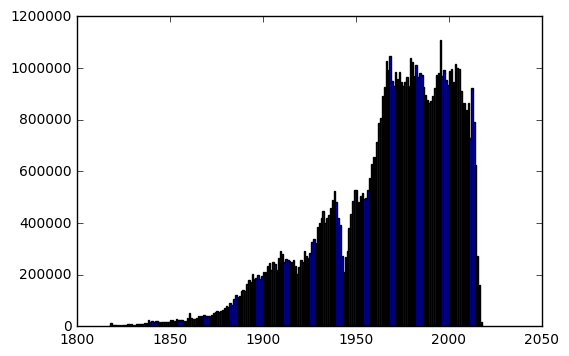

In [12]:
plt.bar(pandas_year_summary["yearcollected"], 
        pandas_year_summary["count"]
        edgecolor='none', width=1.0
       )